In [4]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Sequential

#transfer learning
from keras.applications.inception_v3 import InceptionV3

#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

we are currently using tensorflow version 2.10.0


In [2]:
input_shape_2D=(250,250)
input_shape_3D= (250,250,3)
seed=42
batch_size=32
epochs=10

In [3]:
#loading image data
data_ds= tf.keras.utils.image_dataset_from_directory(
    directory='data/RiceLeafsDisease/train/',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=input_shape_2D,
    seed=seed
)

Found 2100 files belonging to 6 classes.


2024-04-19 21:33:15.897225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 21:33:15.950590: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-19 21:33:15.951241: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
test_ds= tf.keras.utils.image_dataset_from_directory(
    directory='data/RiceLeafsDisease/validation/',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=None,
    image_size=input_shape_2D,
    seed=seed
)

Found 528 files belonging to 6 classes.


In [5]:
#class labels
class_names = data_ds.class_names

print("Class Names:", class_names)

Class Names: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


In [6]:
X=[]
y= []

for image, label in data_ds.batch(2099):
  for img, lab in zip(image, label):
    X.append(img)
    y.append(lab.numpy())

In [7]:
# converting to numpy array
X= np.array(X)
y= np.array(y)

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [9]:
X_train = X_train/255
X_test = X_test/255

In [10]:
print("shape of X_train_scaled:", X_train.shape)
print("shape of y_train:", y_train.shape)
print("shape of X_test_scaled:", X_test.shape)
print("shape of y_test:", y_test.shape)

shape of X_train_scaled: (1680, 250, 250, 3)
shape of y_train: (1680,)
shape of X_test_scaled: (420, 250, 250, 3)
shape of y_test: (420,)


In [11]:
y_train = to_categorical(y_train, num_classes=len(class_names))
y_test = to_categorical(y_test, num_classes=len(class_names))

## Inception

In [5]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

for layer in base_model.layers:
    layer.trainable=False

model = Sequential()
model.add(base_model)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.25))
model.add(Dense(6, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 batch_normalization_188 (Ba  (None, 6, 6, 2048)       8192      
 tchNormalization)                                               
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 23,915,302
Trainable params: 2,108,422
Non

In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
import time
# Record the start time of training
start_time = time.time()

In [16]:
epochs = 10

#Training
inception_history=model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=epochs
)

Epoch 1/10


2024-04-19 21:34:30.748702: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-19 21:34:36.268446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-19 21:34:36.739346: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x42e6f0c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-19 21:34:36.739534: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-04-19 21:34:36.912974: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-19 21:34:37.651703: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

53/53 [==============================] - 23s 128ms/step - loss: 1.0705 - accuracy: 0.6048 - val_loss: 1.5061 - val_accuracy: 0.4286
Epoch 2/10
53/53 [==============================] - 2s 44ms/step - loss: 0.5180 - accuracy: 0.8262 - val_loss: 0.6906 - val_accuracy: 0.7405
Epoch 3/10
53/53 [==============================] - 2s 46ms/step - loss: 0.2978 - accuracy: 0.9113 - val_loss: 0.4199 - val_accuracy: 0.8310
Epoch 4/10
53/53 [==============================] - 2s 45ms/step - loss: 0.1807 - accuracy: 0.9482 - val_loss: 0.4745 - val_accuracy: 0.8333
Epoch 5/10
53/53 [==============================] - 3s 48ms/step - loss: 0.0986 - accuracy: 0.9780 - val_loss: 0.4234 - val_accuracy: 0.8548
Epoch 6/10
53/53 [==============================] - 2s 45ms/step - loss: 0.0650 - accuracy: 0.9869 - val_loss: 0.3071 - val_accuracy: 0.8881
Epoch 7/10
53/53 [==============================] - 2s 44ms/step - loss: 0.0472 - accuracy: 0.9923 - val_loss: 0.3178 - val_accuracy: 0.8786
Epoch 8/10
53/53 [====

In [17]:
# Record the training end time
end_time = time.time()

In [18]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 51.54139280319214 seconds


In [19]:
pd.DataFrame(inception_history.history)

,loss,accuracy,val_loss,val_accuracy
0,1.070466,0.604762,1.506139,0.428571
1,0.517985,0.826190,0.690586,0.740476
2,0.297812,0.911310,0.419926,0.830952
3,0.180659,0.948214,0.474470,0.833333
4,0.098629,0.977976,0.423372,0.854762
5,0.065004,0.986905,0.307117,0.888095
6,0.047167,0.992262,0.317772,0.878571
7,0.060187,0.983929,0.374198,0.876190
8,0.025840,0.997024,0.226683,0.930952
9,0.012667,0.999405,0.222018,0.940476


In [20]:
import joblib
joblib.dump(inception_history.history,'history_inception.pkl')
inception_history = joblib.load('history_inception.pkl')

In [21]:
def plot_performance(model_name, acc, val_acc, loss, val_loss):
  plt.figure(figsize=(10,5))
  plt.subplot(1,2,1)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('{} : Loss'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='upper right')

  plt.subplot(1,2,2)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('{} : Accuracy'.format(model_name), fontsize=12, fontweight='bold')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['train', 'test'], loc='lower right')

  plt.tight_layout()

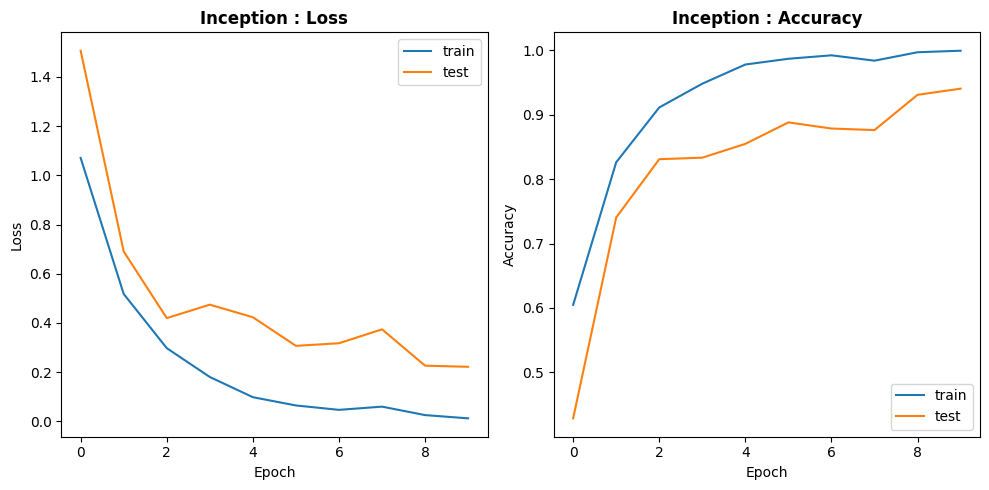

In [22]:
plot_performance(model_name='Inception',
                acc=inception_history['accuracy'], 
                 val_acc=inception_history['val_accuracy'],
                 loss=inception_history['loss'], 
                 val_loss=inception_history['val_loss'])

In [24]:
model.save('inception_model.h5')